# EMF Data Multicollinearity Analysis

This notebook analyzes multicollinearity in the EMF dataset using various methods:
- Correlation Matrix
- Heatmap Visualization
- Variance Inflation Factor (VIF)
- Feature Selection based on multicollinearity

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Data

In [3]:
# Load the cleaned EMF data
df = pd.read_csv('EMF_Data_Cleaned.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (4850, 9)

First few rows:


,sample_id,temperature_C,humidity_percent,load_current_A,distance_from_line_m,vertical_distance_m,E_field_V_m,H_field_A_m,is_outlier
0,1,29.967142,50.647558,535.443405,166.329840,11.239555,11924.681192,0.231436,False
1,2,23.617357,84.772448,1093.503174,16.762860,0.000000,22687.906942,7.797186,False
2,3,31.476885,37.310486,489.801978,192.064283,0.000000,2903.672718,0.406947,False
3,4,40.230299,62.624150,1153.631699,185.534389,0.000000,1618.200497,1.019055,False
4,5,22.658466,61.867436,917.190465,108.330343,0.000000,3804.229392,1.702174,False


In [4]:
# Check data types and missing values
print("Data Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4850 entries, 0 to 4849
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sample_id             4850 non-null   int64  
 1   temperature_C         4850 non-null   float64
 2   humidity_percent      4850 non-null   float64
 3   load_current_A        4850 non-null   float64
 4   distance_from_line_m  4850 non-null   float64
 5   vertical_distance_m   4850 non-null   float64
 6   E_field_V_m           4850 non-null   float64
 7   H_field_A_m           4850 non-null   float64
 8   is_outlier            4850 non-null   bool   
dtypes: bool(1), float64(7), int64(1)
memory usage: 308.0 KB

Missing Values:
sample_id               0
temperature_C           0
humidity_percent        0
load_current_A          0
distance_from_line_m    0
vertical_distance_m     0
E_field_V_m             0
H_field_A_m             0
is_outlier              0
dtype: int

## 2. Select Numerical Features

In [5]:
# Select only numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Create a dataframe with only numerical features
df_numerical = df[numerical_cols].copy()

Numerical columns (8): ['sample_id', 'temperature_C', 'humidity_percent', 'load_current_A', 'distance_from_line_m', 'vertical_distance_m', 'E_field_V_m', 'H_field_A_m']


## 3. Correlation Matrix Analysis

In [6]:
# Calculate correlation matrix
correlation_matrix = df_numerical.corr()

print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


,sample_id,temperature_C,humidity_percent,load_current_A,distance_from_line_m,vertical_distance_m,E_field_V_m,H_field_A_m
sample_id,1.000000,-0.027013,-0.001857,0.005789,-0.002154,0.019017,0.004907,0.005652
temperature_C,-0.027013,1.000000,0.009853,0.004017,-0.014372,-0.002925,0.013955,0.006181
humidity_percent,-0.001857,0.009853,1.000000,-0.028526,0.008900,-0.035325,-0.023410,-0.018596
load_current_A,0.005789,0.004017,-0.028526,1.000000,-0.020247,-0.020649,-0.009525,0.321578
distance_from_line_m,-0.002154,-0.014372,0.008900,-0.020247,1.000000,0.009008,-0.455909,-0.732209
vertical_distance_m,0.019017,-0.002925,-0.035325,-0.020649,0.009008,1.000000,0.465481,0.116193
E_field_V_m,0.004907,0.013955,-0.023410,-0.009525,-0.455909,0.465481,1.000000,0.708742
H_field_A_m,0.005652,0.006181,-0.018596,0.321578,-0.732209,0.116193,0.708742,1.000000


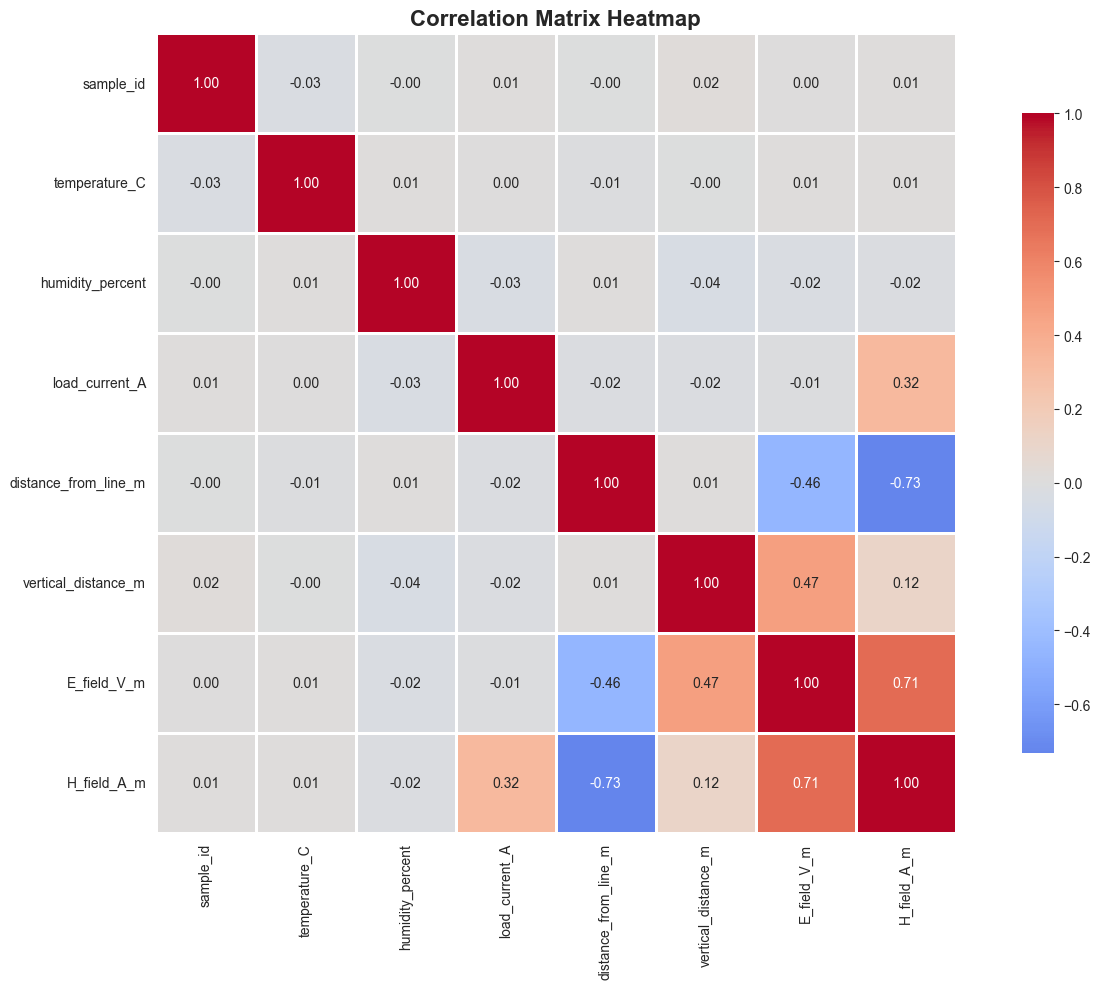

In [7]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Identify High Correlations

In [8]:
# Find highly correlated feature pairs (correlation > 0.8)
def get_high_correlations(corr_matrix, threshold=0.8):
    """
    Find pairs of features with correlation above threshold
    """
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                high_corr_pairs.append([
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ])
    
    return pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Get high correlations
high_corr = get_high_correlations(correlation_matrix, threshold=0.8)

if len(high_corr) > 0:
    print(f"\nFound {len(high_corr)} pairs with correlation >= 0.8:")
    print(high_corr.sort_values('Correlation', ascending=False))
else:
    print("\nNo feature pairs found with correlation >= 0.8")


No feature pairs found with correlation >= 0.8


In [9]:
# Find moderately correlated feature pairs (0.6 to 0.8)
moderate_corr = get_high_correlations(correlation_matrix, threshold=0.6)
moderate_corr = moderate_corr[abs(moderate_corr['Correlation']) < 0.8]

if len(moderate_corr) > 0:
    print(f"\nFound {len(moderate_corr)} pairs with correlation between 0.6 and 0.8:")
    print(moderate_corr.sort_values('Correlation', ascending=False))
else:
    print("\nNo feature pairs found with correlation between 0.6 and 0.8")


Found 2 pairs with correlation between 0.6 and 0.8:
              Feature 1    Feature 2  Correlation
1           E_field_V_m  H_field_A_m     0.708742
0  distance_from_line_m  H_field_A_m    -0.732209


## 5. Variance Inflation Factor (VIF) Analysis

In [10]:
# Calculate VIF for each feature
def calculate_vif(dataframe):
    """
    Calculate VIF for all features
    VIF > 10: High multicollinearity
    VIF > 5: Moderate multicollinearity
    VIF < 5: Low multicollinearity
    """
    vif_data = pd.DataFrame()
    vif_data['Feature'] = dataframe.columns
    vif_data['VIF'] = [variance_inflation_factor(dataframe.values, i) 
                       for i in range(len(dataframe.columns))]
    return vif_data.sort_values('VIF', ascending=False)

# Calculate VIF
print("Calculating Variance Inflation Factor (VIF)...\n")
vif_results = calculate_vif(df_numerical)
print(vif_results)

Calculating Variance Inflation Factor (VIF)...

                Feature        VIF
3        load_current_A  17.528122
7           H_field_A_m  13.311756
1         temperature_C   6.062384
6           E_field_V_m   5.269886
4  distance_from_line_m   5.267926
2      humidity_percent   5.191371
0             sample_id   3.628863
5   vertical_distance_m   1.847029


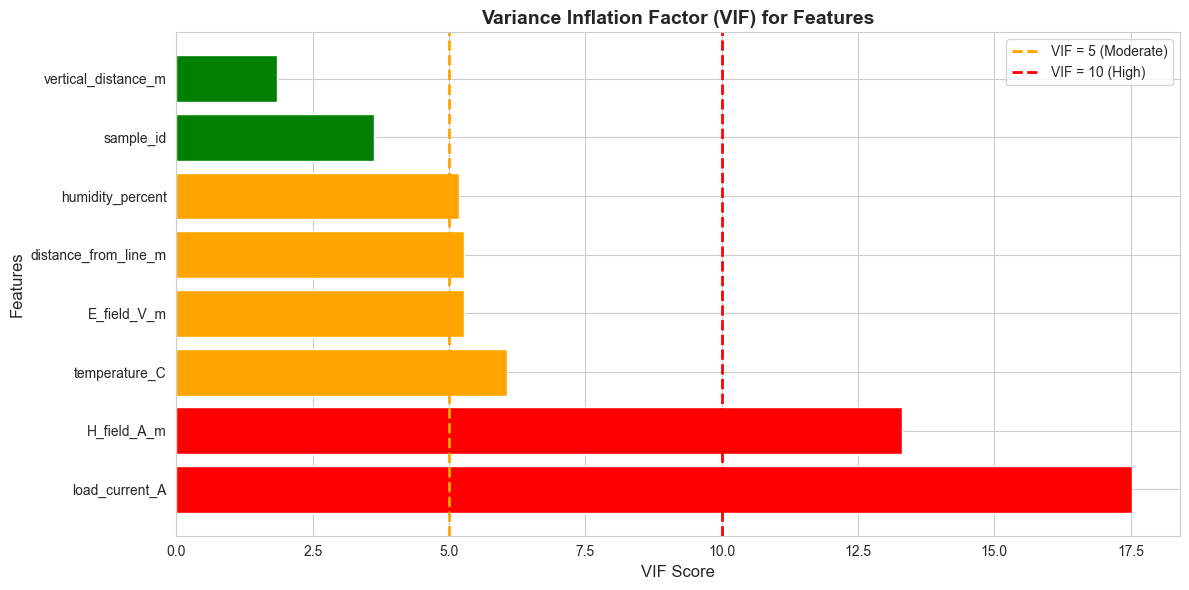


VIF INTERPRETATION
Features with HIGH multicollinearity (VIF > 10): 2
          Feature        VIF
3  load_current_A  17.528122
7     H_field_A_m  13.311756

Features with MODERATE multicollinearity (5 < VIF <= 10): 4
                Feature       VIF
1         temperature_C  6.062384
6           E_field_V_m  5.269886
4  distance_from_line_m  5.267926
2      humidity_percent  5.191371


In [11]:
# Visualize VIF scores
plt.figure(figsize=(12, 6))
colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in vif_results['VIF']]
plt.barh(vif_results['Feature'], vif_results['VIF'], color=colors)
plt.xlabel('VIF Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Variance Inflation Factor (VIF) for Features', fontsize=14, fontweight='bold')
plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5 (Moderate)')
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 10 (High)')
plt.legend()
plt.tight_layout()
plt.show()

# Interpretation
high_vif = vif_results[vif_results['VIF'] > 10]
moderate_vif = vif_results[(vif_results['VIF'] > 5) & (vif_results['VIF'] <= 10)]

print(f"\n{'='*50}")
print("VIF INTERPRETATION")
print(f"{'='*50}")
print(f"Features with HIGH multicollinearity (VIF > 10): {len(high_vif)}")
if len(high_vif) > 0:
    print(high_vif)
    
print(f"\nFeatures with MODERATE multicollinearity (5 < VIF <= 10): {len(moderate_vif)}")
if len(moderate_vif) > 0:
    print(moderate_vif)

## 6. Remove High Multicollinearity Features

In [12]:
# Function to iteratively remove features with high VIF
def remove_high_vif_features(dataframe, threshold=10):
    """
    Iteratively remove features with VIF > threshold
    """
    df_reduced = dataframe.copy()
    removed_features = []
    
    while True:
        vif_data = calculate_vif(df_reduced)
        max_vif = vif_data['VIF'].max()
        
        if max_vif > threshold:
            feature_to_remove = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
            removed_features.append((feature_to_remove, max_vif))
            print(f"Removing '{feature_to_remove}' with VIF = {max_vif:.2f}")
            df_reduced = df_reduced.drop(columns=[feature_to_remove])
        else:
            break
    
    return df_reduced, removed_features

# Remove features with VIF > 10
print("Removing features with VIF > 10...\n")
df_reduced, removed = remove_high_vif_features(df_numerical, threshold=10)

print(f"\n{'='*50}")
print(f"Original features: {df_numerical.shape[1]}")
print(f"Remaining features: {df_reduced.shape[1]}")
print(f"Removed features: {len(removed)}")
print(f"{'='*50}")

Removing features with VIF > 10...

Removing 'load_current_A' with VIF = 17.53

Original features: 8
Remaining features: 7
Removed features: 1



VIF scores after removing high multicollinearity features:

                Feature       VIF
6           H_field_A_m  6.275219
1         temperature_C  5.553232
2      humidity_percent  4.967640
5           E_field_V_m  4.243205
0             sample_id  3.517798
3  distance_from_line_m  3.237332
4   vertical_distance_m  1.796889
                Feature       VIF
6           H_field_A_m  6.275219
1         temperature_C  5.553232
2      humidity_percent  4.967640
5           E_field_V_m  4.243205
0             sample_id  3.517798
3  distance_from_line_m  3.237332
4   vertical_distance_m  1.796889


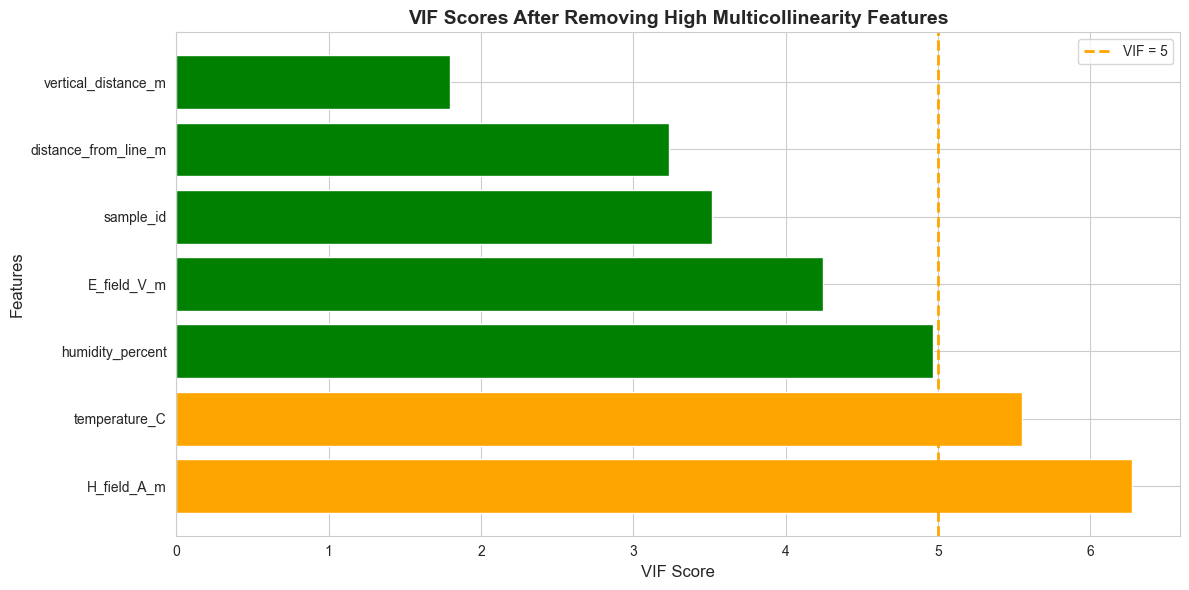

In [13]:
# Recalculate VIF for remaining features
if df_reduced.shape[1] > 0:
    print("\nVIF scores after removing high multicollinearity features:\n")
    vif_final = calculate_vif(df_reduced)
    print(vif_final)
    
    # Visualize final VIF scores
    plt.figure(figsize=(12, 6))
    colors = ['orange' if x > 5 else 'green' for x in vif_final['VIF']]
    plt.barh(vif_final['Feature'], vif_final['VIF'], color=colors)
    plt.xlabel('VIF Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title('VIF Scores After Removing High Multicollinearity Features', 
              fontsize=14, fontweight='bold')
    plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 7. Correlation Matrix After Feature Removal

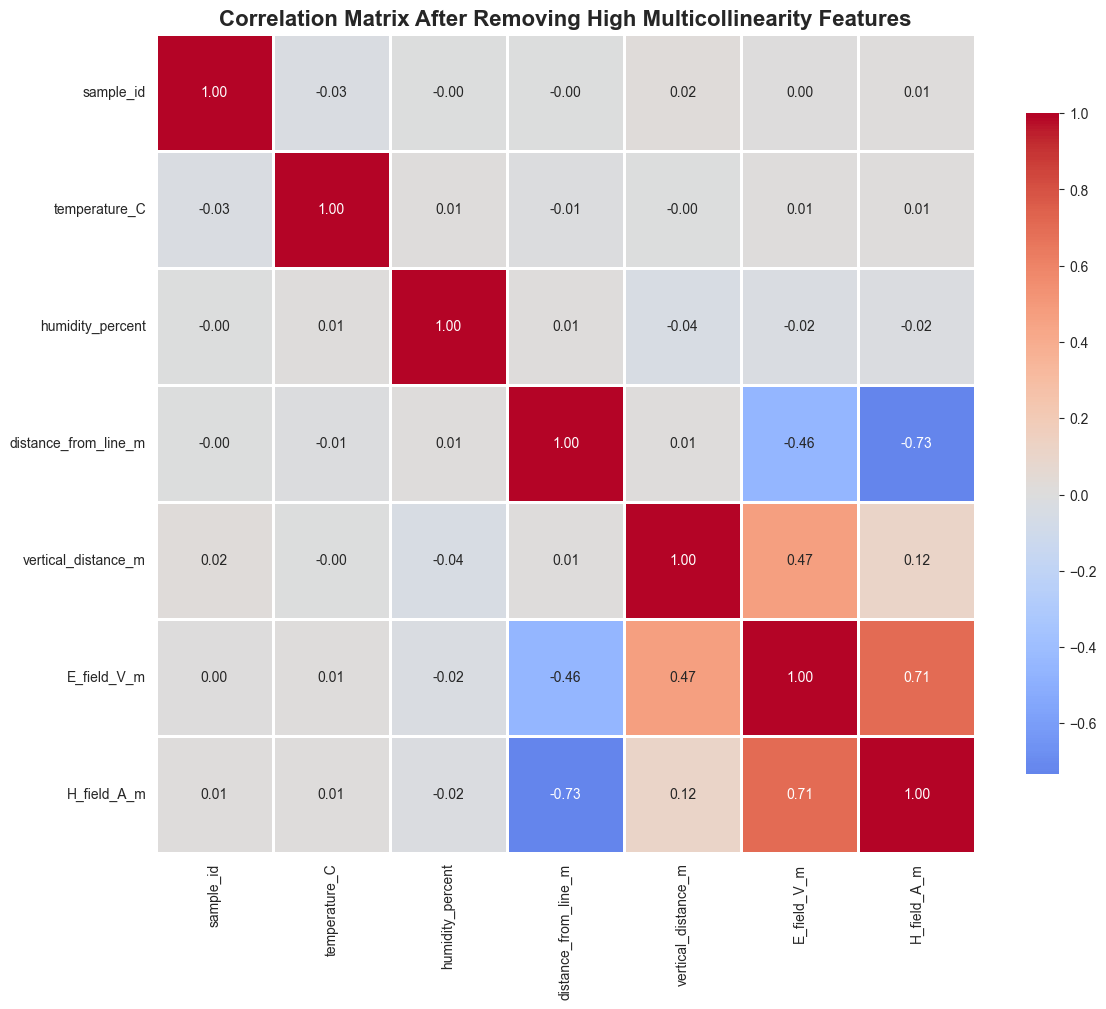

In [14]:
# Create correlation matrix for reduced dataset
if df_reduced.shape[1] > 0:
    correlation_reduced = df_reduced.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_reduced, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=1,
                cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix After Removing High Multicollinearity Features', 
              fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 8. Save Results

In [15]:
# Save the dataset with reduced features
if df_reduced.shape[1] > 0:
    # Combine with non-numerical columns if any
    non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    
    if len(non_numerical_cols) > 0:
        df_final = pd.concat([df[non_numerical_cols], df_reduced], axis=1)
    else:
        df_final = df_reduced
    
    # Save to CSV
    output_file = 'EMF_Data_No_Multicollinearity.csv'
    df_final.to_csv(output_file, index=False)
    print(f"\nDataset with reduced multicollinearity saved to: {output_file}")
    print(f"Shape: {df_final.shape}")


Dataset with reduced multicollinearity saved to: EMF_Data_No_Multicollinearity.csv
Shape: (4850, 8)


In [16]:
# Save multicollinearity report
with open('Multicollinearity_Report.txt', 'w') as f:
    f.write("EMF Data Multicollinearity Analysis Report\n")
    f.write("=" * 60 + "\n\n")
    
    f.write(f"Original Dataset Shape: {df.shape}\n")
    f.write(f"Numerical Features: {len(numerical_cols)}\n\n")
    
    f.write("High Correlation Pairs (|r| >= 0.8):\n")
    f.write("-" * 60 + "\n")
    if len(high_corr) > 0:
        f.write(high_corr.to_string(index=False))
    else:
        f.write("None found\n")
    f.write("\n\n")
    
    f.write("VIF Analysis (Original Features):\n")
    f.write("-" * 60 + "\n")
    f.write(vif_results.to_string(index=False))
    f.write("\n\n")
    
    f.write("Features Removed Due to High VIF (> 10):\n")
    f.write("-" * 60 + "\n")
    if removed:
        for feature, vif in removed:
            f.write(f"  - {feature}: VIF = {vif:.2f}\n")
    else:
        f.write("None\n")
    f.write("\n")
    
    if df_reduced.shape[1] > 0:
        f.write("VIF Analysis (After Feature Removal):\n")
        f.write("-" * 60 + "\n")
        f.write(vif_final.to_string(index=False))
        f.write("\n\n")
    
    f.write(f"\nFinal Dataset Shape: {df_final.shape}\n")
    f.write(f"Features Retained: {df_reduced.shape[1]}\n")

print("\nMulticollinearity report saved to: Multicollinearity_Report.txt")


Multicollinearity report saved to: Multicollinearity_Report.txt


## 9. Summary and Recommendations

In [17]:
print("=" * 70)
print("MULTICOLLINEARITY ANALYSIS SUMMARY")
print("=" * 70)
print(f"\n1. Original Dataset:")
print(f"   - Total Features: {df.shape[1]}")
print(f"   - Numerical Features: {len(numerical_cols)}")
print(f"   - Samples: {df.shape[0]}")

print(f"\n2. High Correlations (|r| >= 0.8):")
print(f"   - Pairs Found: {len(high_corr)}")

print(f"\n3. VIF Analysis:")
print(f"   - Features with VIF > 10: {len(high_vif)}")
print(f"   - Features with VIF 5-10: {len(moderate_vif)}")

print(f"\n4. Feature Reduction:")
print(f"   - Features Removed: {len(removed)}")
print(f"   - Features Retained: {df_reduced.shape[1]}")

print(f"\n5. Recommendations:")
if len(removed) > 0:
    print(f"   - Use 'EMF_Data_No_Multicollinearity.csv' for modeling")
    print(f"   - {len(removed)} features were removed to reduce multicollinearity")
    print(f"   - All remaining features have VIF <= 10")
else:
    print(f"   - No severe multicollinearity detected")
    print(f"   - Original dataset can be used for modeling")

if len(moderate_vif) > 0:
    print(f"   - Monitor {len(moderate_vif)} features with moderate VIF (5-10)")

print("\n" + "=" * 70)

MULTICOLLINEARITY ANALYSIS SUMMARY

1. Original Dataset:
   - Total Features: 9
   - Numerical Features: 8
   - Samples: 4850

2. High Correlations (|r| >= 0.8):
   - Pairs Found: 0

3. VIF Analysis:
   - Features with VIF > 10: 2
   - Features with VIF 5-10: 4

4. Feature Reduction:
   - Features Removed: 1
   - Features Retained: 7

5. Recommendations:
   - Use 'EMF_Data_No_Multicollinearity.csv' for modeling
   - 1 features were removed to reduce multicollinearity
   - All remaining features have VIF <= 10
   - Monitor 4 features with moderate VIF (5-10)

